# Introduction
1. Name : Cindra C
2. Batch : 9 FTDS


**Background** : 

Have you ever thought about "`why the government build a high class station like Gambir in Central Jakarta? why not in East Jakarta for example?`"

or
"`Oh, my homeland used to have a huge annual crop area. Lots of forest and pasture. Now it turned into Industrial Area. I wonder why it's changed`."

Either it is YES or NO, the answer that lies beyond that question is Geographical Informatic System (GIS).

In a simple words, GIS is a way for us to create a map. Map of Land Use, Map of Railways, Map of Elevation, etc. And further, those map can be a `tools` to predict something. But in order to create that map, we need to interprete what we see from the imagery.

Photographic interpretation is a major part of GIS. It involves analyzing aerial photographs and assessing the features that appear. An example of this kind of information is computer data collected by satellites that show land use—the location of farms, towns, and forests. Further, those data can be applied to lots of implementations. For example : 
- Development Planning (like building a new station/terminal)
- Response in Natural Disaster (which area that have high probability of Landslides)
- Drought Prediction (When will that area facing drought?)
- Land Evaluation (Is this land good for farming rice? or should I use it for Annual Crop?)
- Etc

**Problem Statement**: 

However, in interpreting the images, all of the surveyor facing a *Subjectivity* in interpreting the images. Some would say that `this is Annual Crop` yet another might say `this is an empty land`. Some might say `This is a river!` yet another might say `It's a road!`. It's all affected by Subjectivity and the quality of images we have. Miss interpreting an images could refer to missclassification and worst case scenario wrong action to specific area. Well, we don't want that to happen, right?


**Objective**:

Therefore this model is created. To automatically classify land use/land cover to help those surveyor interpreting a land use by satelite imagery. At least we have minimalizing their subjectivity.

You may download the datasets from [Kaggle](https://www.kaggle.com/datasets/pranjallk1995/rgbeurosat)


# Import Library

In [1]:
!nvidia-smi #check what free nvidia we use,
#for this data and model, T4 perform better than K40
#if you want to, re-run it and make sure you get T4 :)

Fri Apr 22 18:48:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import glob

import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Rescaling

from sklearn.metrics import classification_report
# import warnings
# warnings.filterwarnings('ignore')

# Load Data
Since im using data from kaggle, this code only works for Google Colab with loading data from Kaggle API

In [3]:
!mkdir -p ~/.kaggle #directing to kaggle folder
!cp kaggle.json ~/.kaggle #make sure you've downloaded kaggle.json and upload it on Google Colab
!mkdir ./kaggle 
!mv ./kaggle.json ./kaggle 

In [4]:
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d pranjallk1995/rgbeurosat #this is the API Link from Kaggle set

 90% 81.0M/89.8M [00:02<00:00, 29.6MB/s]
100% 89.8M/89.8M [00:02<00:00, 33.2MB/s]


In [6]:
!unzip -q /content/rgbeurosat.zip -d ML2 #unzip it and save it on ML2 Folder

# EDA

In [7]:
main_path = '/content/ML2/RBG' #create path for data

train_dir = os.path.join(main_path, 'train') #path for train
test_dir = os.path.join(main_path, 'test') #path for test
val_dir = os.path.join(main_path, 'val') #path for val

LABELS = os.listdir(train_dir) #declaring the labels that exist in this dataset
print(f'The Land Classification that exist in this data sets are\n{list(LABELS)}\n\
In Total, There are {len(LABELS)} Land Classifications')

The Land Classification that exist in this data sets are
['AnnualCrop', 'Industrial', 'Pasture', 'PermanentCrop', 'Highway', 'Residential', 'Forest', 'River', 'SeaLake', 'HerbaceousVegetation']
In Total, There are 10 Land Classifications


> I only provide you 10 classes of land use here. Somehow, in Indonesia, all of the Land Use Classificaiton have it's own Rule that owned by BIG. There are lots of classification and it's related on the map's scale. You might visit [land use classification](https://www.big.go.id/assets/download/sni/SNI/15.%20SNI%207645-2010%20Klasifikasi%20penutup%20lahan.pdf) to know how much classification we can make 😺.

In [8]:
#counting datas in each labels

#trainset
print('In Train Set,')
for path, name, file in os.walk(train_dir):
  if path.split("/")[-1] != 'train':
    print(f'There are {len(file)} images labeled as {path.split("/")[-1]}')

#testset
print('\nIn Test Set,')
for path, name, file in os.walk(test_dir):
  if path.split("/")[-1] != 'test':
    print(f'There are {len(file)} images labeled as {path.split("/")[-1]}')

In Train Set,
There are 2400 images labeled as AnnualCrop
There are 2000 images labeled as Industrial
There are 1600 images labeled as Pasture
There are 2000 images labeled as PermanentCrop
There are 2000 images labeled as Highway
There are 2400 images labeled as Residential
There are 2400 images labeled as Forest
There are 2000 images labeled as River
There are 2400 images labeled as SeaLake
There are 2400 images labeled as HerbaceousVegetation

In Test Set,
There are 300 images labeled as AnnualCrop
There are 250 images labeled as Industrial
There are 200 images labeled as Pasture
There are 250 images labeled as PermanentCrop
There are 250 images labeled as Highway
There are 300 images labeled as Residential
There are 300 images labeled as Forest
There are 250 images labeled as River
There are 300 images labeled as SeaLake
There are 300 images labeled as HerbaceousVegetation


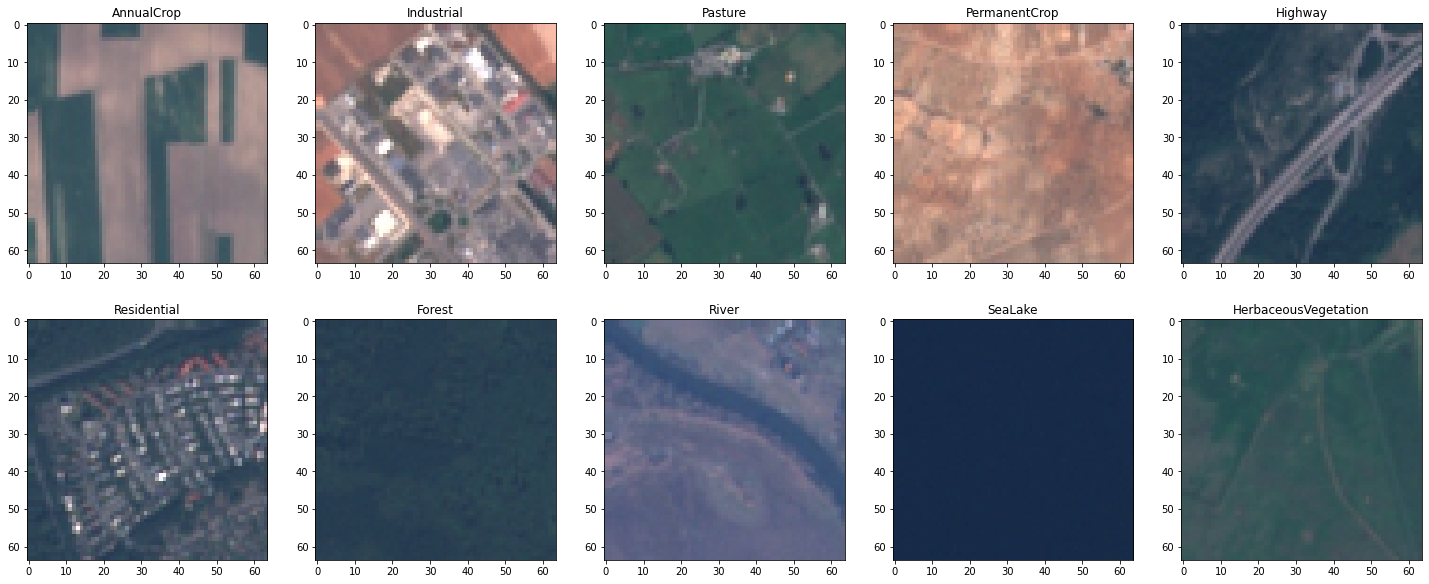

In [9]:
#plot the picture with labels
fig, ax = plt.subplots(2,5, figsize=(25,10))
for y in range(2) :
  for x in range (5):
    sample = glob.glob(f"{train_dir}/{LABELS[y*5 + x]}/*.jpg")[0]
    ax[y, x].imshow(Image.open(sample))
    ax[y, x].set_title(f'{LABELS[y*5 + x]}')

> The explanation for each classes =
>> 1. SeaLake only consist dark color without any shape and texture
>> 2. Industrial have squared shape, less bright, the pattern is obvious, the texture is normal
>> 3. Pasture consist green colour with smooth texture, no specific pattern or shape here.
>> 4. Forest is dark, it's supposed to be dark green. The texture is normal (tends to smooth) and there is no shape in forest picture
>> 5. River consist of line shaped like super long rectangular, the texture is super smooth, somehow the lines is not strictly straight, it can be curved.
>> 6. Residential textures is hard, the color is bright,and variative, it has less green colour.
>> 7. PermanentCrop have rectangular shape, the texture is super smooth, the pattern of the shape is specific. The color consist green and creamy, tends to have bright colour
>> 8. Herbaceous Vegetation texture is hard, majorly green and creamy colour and its bright. But it doesn't have shape and patterns (ABSTRACT)
>> 9. Annual Crop is similar with PermanentCrop. It has ovious pattern and long rectangular shape. The things that mkaes it different with permanent crop is the majority of color. Annual Crop seems to have brighter creamy color.
>> 10. Highway consist ots of curved lines with smooth textures. The colour is gray colour

> Theoritically, every land use has its own defintion. In Indonesia, BIG explained [land use classification](https://www.big.go.id/assets/download/sni/SNI/15.%20SNI%207645-2010%20Klasifikasi%20penutup%20lahan.pdf) and its function. It explain us what is forest, what is annualcrop, what is permanentcrop, etc. But it doesn't explain how to classify it through satlite.  A document released by *The Ministry of Environment and Foresty* actually explained how to classify the image in text[here](https://geoportal.menlhk.go.id/~appgis/publikasi/Lainnya/Peraturan%20Terkait/RSNI_1b_KELAS%20PENUTUPAN%20LAHAN%20DALAM%20PENAFSIRAN%20CITRA%20OPTIS%20RESOLUSI%20SEDANG.pdf) 

> But this is hard for human to interpret it. There are lots of studies in with detailed pictures actually, but do we really need to spend out time browsing ? while actually there is a `system/machine` that can automatically interpret the images?

> Lets take a look in Residential image in this data, it actually looks like a Highway, right? Because it's straight and smooth. Slightly it's similar with Highway. The differences is only : highway has smoother texture and bigger width, while the residential is having a pattern and hard texture. 

> To sum-up what it looks like for each class, every tone of colour, brightness, texture, pattern **does really matters** here.

> Anyway, from the plots above we know that this datasets is having `small size` since its only have 64x64 dimension

# Data Preprocessing

In [10]:
#setting up variables
BATCH = 256
SEED = 55
img_height = 64 #reflected to our image
img_width = 64 #our image only have 64 * 64 size
inputs= [img_height,img_width,3] #3 channels : RGB


callbacks = [EarlyStopping(monitor = 'val_loss', 
                           patience = 8, 
                           restore_best_weights=True)]

> Batch and Seed is just a random set up. But I personally set batch to be higher to minimze the computation and time cost realted to image processing. Previously I've tried to use BATCH = 128, it take long time to train, higher size of model to save, and the val_loss is quite same result with BATCH = 256. Let's take an easier and faster way :)

> I've set an EarlyStopp because in processing image, we might take a long time to process. And I need to stop it right when the metrics (val_loss) is stopped improving. I'm having a limited GPU so I want my GPU to work max that's why I set the patience to 8. The purpose is to patiently wait for the val_loss reaching it's global minima, and using the GPU efficiently. I've tried to use patience like 3 & 5, but in order to have a better result with efficient GPU, I increase it to 8. Believing that this will result better without having low performance

> I don't set up the callbacks with ModelCheckpoint because I just want to use my lucky chance to overwrite the model when I retrained the model. Eventho this cost my time, but here i tried lots of trial and error, and I only personally want to have better understanding in my architectures

In [11]:
#augmentation
train_datagen = ImageDataGenerator(
    brightness_range = [0.3, 0.9], 
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

> I set rescaling in every Model I use below

> I told you that every texture, colour, brightness, and pattern **MATTERS** in classifying land use. Therefore i brightness range as the color parameters, and others parameters as the pattern that needed to be learned by our models. As far as I understand, the pattern here don't really need to be `variative`. Let's think about it : a rice fields is always Square Shape, probably a little shear when it's needed. There's no Circle rice fields, right? That's why i set all of the pattern parameters with low score. Somehow I do believe that we don't really need to set up horizontal_flip since the flip here don't really work for land use, but it's fine. Who knows that we're going to get a better score, right?

In [12]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                target_size=(64,64), batch_size= BATCH, 
                                seed=SEED, class_mode='categorical') #pipeline

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(64,64),
                                batch_size= BATCH, seed=SEED, 
                                class_mode='categorical') #pipeline

Found 21600 images belonging to 10 classes.
Found 2700 images belonging to 10 classes.


In [13]:
#maps for labels
maps = train_generator.class_indices
maps

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

> Those maps aboved is necessary for labeling multiclass data

Text(0.5, 1.0, 'Original')

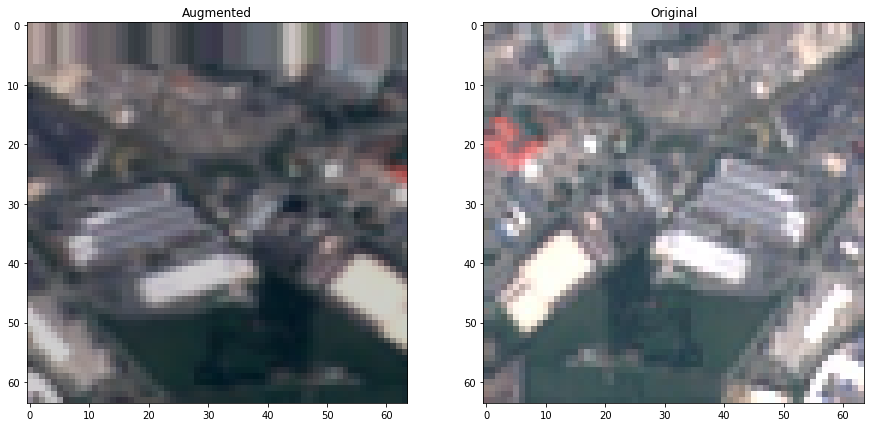

In [14]:
# Show augmented images
images, labels  = next(train_generator)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax[0].imshow(images[0]/255.)
ax[0].set_title('Augmented')
original = plt.imread(train_generator.filepaths[train_generator.index_array[BATCH*(train_generator.batch_index-1)]])
ax[1].imshow(original)
ax[1].set_title('Original')

> Those augmentated images above is an images with this parameters :
> - brightness_range = [0.3, 0.9], 
> - rotation_range=0.1,
> - width_shift_range=0.2,
> - height_shift_range=0.2,
> - shear_range=0.2,
> - zoom_range=0.2,
> - horizontal_flip=True

In [15]:
#save dict maps for deployment purpose
import pickle
with open ("dictionary_class.pkl", "wb") as f :
    pickle.dump(maps, f)

# Model Definition

In [16]:
model = Sequential()
model.add(Rescaling(1/127.5, offset=-1))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same',
                 activation = 'relu', input_shape = inputs))
model.add(MaxPool2D(pool_size=(2,2))) #from 64 to 32


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2))) #from 32 to 16


model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same',
                 activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2))) #from 16 to 8

#not going to make it 4 because it'll be too SMALL and not representing anything


model.add(Flatten())
model.add(Dense(units= 128, activation='relu'))

model.add(Dense(units=10, activation='softmax')) #output have 10 labels

model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

> Remember that my image is only sized 64 * 64. Therefore I only create 3 layers here. Why ? Because :
>> 1. Each layers we create is always decreasing the size of our image (look at my #64 to 32). This explain that in first layer, the original size from 64 turned into 32. 
>> 2. Because the size is always decreased, we need to increase the filters in order the model to learn better and extract information in that picture.
>> 3. Activation = relu here is use based on it's popularity, nothing specific. When the metrics is not good, maybe we can change the activation (or not?)

# Model Training

With the understanding of processing image computation, I only set epochs = 100 as limitation. I've tried to set it up to 512 but it ended up stopped at 50 epochs because I've set Earlystopping wth patience=8 above.

In [17]:
history = model.fit(train_generator, validation_data = val_generator, 
                    callbacks = callbacks, epochs = 100) #40s/epochs

Epoch 1/100
85/85 [==============================] - 41s 454ms/step - loss: 1.5875 - accuracy: 0.3855 - val_loss: 1.6412 - val_accuracy: 0.3785
Epoch 2/100
85/85 [==============================] - 37s 431ms/step - loss: 1.1683 - accuracy: 0.5656 - val_loss: 1.6036 - val_accuracy: 0.3926
Epoch 3/100
85/85 [==============================] - 36s 425ms/step - loss: 1.0052 - accuracy: 0.6392 - val_loss: 1.2897 - val_accuracy: 0.5200
Epoch 4/100
85/85 [==============================] - 36s 423ms/step - loss: 0.9026 - accuracy: 0.6720 - val_loss: 1.2178 - val_accuracy: 0.5404
Epoch 5/100
85/85 [==============================] - 36s 422ms/step - loss: 0.8406 - accuracy: 0.7000 - val_loss: 1.1853 - val_accuracy: 0.5252
Epoch 6/100
85/85 [==============================] - 36s 425ms/step - loss: 0.7471 - accuracy: 0.7377 - val_loss: 1.2412 - val_accuracy: 0.5296
Epoch 7/100
85/85 [==============================] - 36s 425ms/step - loss: 0.7339 - accuracy: 0.7382 - val_loss: 1.2132 - val_accuracy:

# Model Evaluation

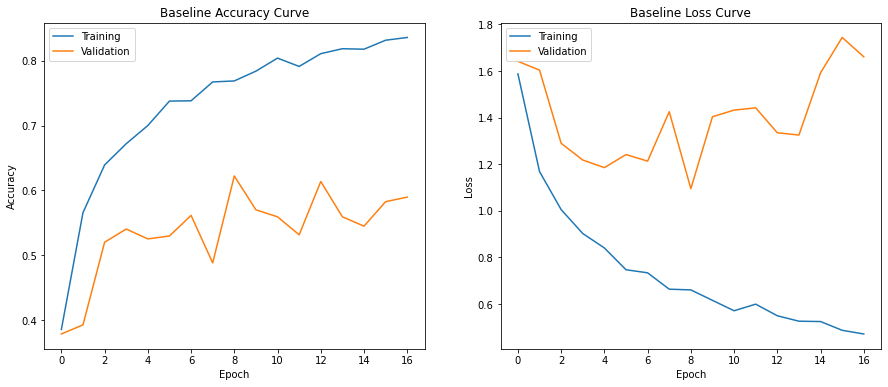

In [18]:
metrics = pd.DataFrame(history.history) #create dataframe of history

#accuracy plot
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics.accuracy, label='Training')
plt.plot(metrics.val_accuracy, label='Validation')
plt.title('Baseline Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#loss plot
plt.subplot(1, 2, 2)
plt.plot(metrics.loss, label='Training')
plt.plot(metrics.val_loss, label='Validation')
plt.title('Baseline Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

> The baseline model resulting in weird loss and accuracy because it's very unstable in validation data. Let's assume the loss is range from 1.2 - 1.4 and the accuracy is only 0.6. I personally think that this is a bad model. Can I improve our models? Supposed to YES. 

>As far as I know, my Training model is stable enough (the blue line is smooth). This means I need to add layers to to make my model more accurate and config the validation parameters (Dropout, learning rate, etc) to reduce the exploding gradient

> Anyway, what's the trouble maker of my model ? Let's check it on classification report below

In [19]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(64,64),
                                batch_size= BATCH, seed=SEED,
                                class_mode='categorical',
                                shuffle= False) #pipeline

y_ = test_generator.labels      
LABELZ = list(test_generator.class_indices.keys())
# LABELZ

Found 2700 images belonging to 10 classes.


In [20]:
y_pred1 = model.predict(test_generator)
y_pred1 = np.argmax(y_pred1, axis = 1)#.predict resulting in probability & i need
#a concrete value which class are they.

report1 = classification_report(y_,
                               y_pred1,
                               labels = np.arange(10),
                               target_names = LABELZ)
print(report1)

                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.76      0.81       300
              Forest       1.00      0.09      0.16       300
HerbaceousVegetation       0.43      0.86      0.57       300
             Highway       0.80      0.34      0.48       250
          Industrial       0.83      0.96      0.89       250
             Pasture       0.29      0.74      0.42       200
       PermanentCrop       0.50      0.34      0.41       250
         Residential       0.94      0.88      0.91       300
               River       0.86      0.34      0.49       250
             SeaLake       0.78      0.93      0.85       300

            accuracy                           0.63      2700
           macro avg       0.73      0.62      0.60      2700
        weighted avg       0.75      0.63      0.61      2700



> Well, at first trial, my baseline model is good at predicting Industrial classes (0.90 score) and weak in predicting SeaLake (0.34 lowest score). 

> Somehow in second trial, my baseline model is good at predicting Residential (0.9score) and weak in predicting Forest. 

 How's the model analysis ?
>> - If we look at Residential & Industrial, it shows a bright & variative color, with squared shape and rectangular, hard texture, the pattern is significant. 

>> - If we look at Sealake images & Forest, it tends to show darker colour, no pattern, no shape seen, and superly smooth texture. 

>> This create assumption that my baseline model is sensitive with variative color, brightness, and pattern. And insenstive (weak) when the images is unvariative color, dark color, and smooth.

## Model Improvement

### Model Improvement 1
In this model, I am only changing activation with `tanh`. But somehow, I've tried a lots of ways to improve my models. For example: 
- I've changed the learning rate for Adam from 1e-3 to 1e-4
- I add a learnign schedule too! It's applied further
- Change the activation from relu, tanh, and selu
- Add dropout to 0.33 and 0.5 in Full Connected Layer

But the results is not much different with the first models. Due to inability to improved more and limited GPU, I'm unable to wrote down what I've trained it here. The notebook here is only one of 10+ times of trial

In [21]:
_input = tf.keras.layers.Input(shape=inputs)
x = _input
x = tf.keras.layers.Rescaling(1/127.5, offset=-1)(x) #use better scaling

x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'tanh')(x)
x = Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'tanh')(x)
x = MaxPool2D(pool_size=(2,2))(x) #32


x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'tanh')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'tanh')(x)
x = MaxPool2D(pool_size=(2,2))(x)#16


x = Conv2D(filters = 128, kernel_size = (3,3), padding = 'same',activation = 'tanh')(x)
x = MaxPool2D(pool_size=(2,2))(x)#8



x = Flatten()(x)
x = Dense(128, activation='tanh')(x) #use better activation
x = Dropout(0.5)(x)

x = Dense(10, activation='softmax')(x) #output

model2 = tf.keras.models.Model(_input, x)

model2.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                             

> What do I do?
>> - `Add Convolutional Layer`
>> - `Set up Learning Rate for Adam Activation to 1e-3`
>> - `Change Hidden Layer activation to tanh instead of relu`
>> - `Add 0.5 Dropout`

In [22]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3), 
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

history2 = model2.fit(train_generator, validation_data = val_generator, 
                    callbacks = callbacks, epochs = 100)

Epoch 1/100
85/85 [==============================] - 39s 436ms/step - loss: 1.7305 - accuracy: 0.3624 - val_loss: 1.4706 - val_accuracy: 0.4074
Epoch 2/100
85/85 [==============================] - 37s 436ms/step - loss: 1.2387 - accuracy: 0.5517 - val_loss: 1.2807 - val_accuracy: 0.5267
Epoch 3/100
85/85 [==============================] - 37s 433ms/step - loss: 1.0168 - accuracy: 0.6406 - val_loss: 1.4044 - val_accuracy: 0.5211
Epoch 4/100
85/85 [==============================] - 37s 433ms/step - loss: 0.8987 - accuracy: 0.6835 - val_loss: 0.9451 - val_accuracy: 0.6504
Epoch 5/100
85/85 [==============================] - 38s 452ms/step - loss: 0.8279 - accuracy: 0.7136 - val_loss: 0.9663 - val_accuracy: 0.6415
Epoch 6/100
85/85 [==============================] - 37s 431ms/step - loss: 0.7654 - accuracy: 0.7386 - val_loss: 0.8764 - val_accuracy: 0.6989
Epoch 7/100
85/85 [==============================] - 37s 437ms/step - loss: 0.7177 - accuracy: 0.7515 - val_loss: 0.8378 - val_accuracy:

#### Model Improved 1 Evaluation

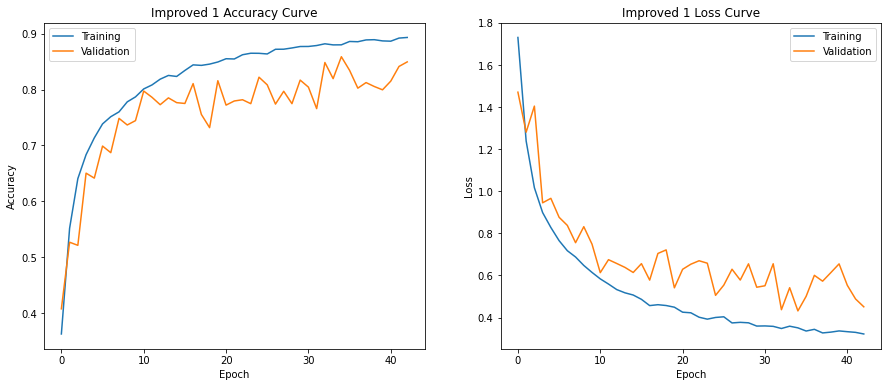

In [23]:
metrics2 = pd.DataFrame(history2.history)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics2.accuracy, label='Training')
plt.plot(metrics2.val_accuracy, label='Validation')
plt.title('Improved 1 Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(metrics2.loss, label='Training')
plt.plot(metrics2.val_loss, label='Validation')
plt.title('Improved 1 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

What is the difference between this improvement and baseline? Woohoo it's improved a lot!. I succeed to reduce loss and increase accuracy. The things that lack here is unstable score for both accuracy and loss

I assume it's because : 
> 1. I need to increase the learning rate and dropout
> 2. I expect it's because my image size is small (64 * 64) and have lots of classes. Well, when human is having trouble in classifing it, then the models is also having a trouble. 

Further, let's check the classificaiotn report below to check how my model is behaving

In [24]:
y_pred2 = model2.predict(test_generator)
y_pred2 = np.argmax(y_pred2, axis = 1)

report2 = classification_report(y_,
                               y_pred2,
                               labels = np.arange(10),
                               target_names = LABELS)
print(report2)

                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.83      0.87       300
          Industrial       0.98      0.86      0.91       300
             Pasture       0.69      0.90      0.78       300
       PermanentCrop       0.97      0.73      0.83       250
             Highway       0.93      0.92      0.93       250
         Residential       0.72      0.96      0.82       200
              Forest       0.81      0.74      0.77       250
               River       0.93      0.98      0.96       300
             SeaLake       0.87      0.71      0.78       250
HerbaceousVegetation       0.90      0.98      0.94       300

            accuracy                           0.86      2700
           macro avg       0.87      0.86      0.86      2700
        weighted avg       0.88      0.86      0.86      2700



> Overall, the classification report is better. What can i analyze here ?

>> - First trial, my model2 is better in predicting Industrial (constat 0.97 score). And weak in predicting HerbaceousVegetation.

>> - Second trial, my model2 is better in predicting HerbaceousVegetation and weak in predicting Forest

> What we can analyze here?

>>  Well, if we look at HerbaceousVegetation images, it have brighter color and hard texture, yet abstract shape. Not much different with baseline mode, it is sensitive with hard texture, but now it's sensitive with abstract shape too

>> In worst, my model2 failed in predicting Forest, similar with my baseline model. This is weak in predicting soft texture and unvariative colour


### Model Improved 2 (Pre Trained)

Somehow I still believe that my model can have a higher accuracy and lower validation loss. Therefore, I want to use pretrained models that keras provided. Take a note that my image is small size (64, 64, 3). I assume I don't need a deep layers. 

Therefore i try to use keras.application VGG16. Why so? Because [Keras](https://keras.io/api/applications/) stated that VGG16 is the lowest depth available. Therefore I tried to use VGG16 instead of any other keras.application.

Furthermore, I set some learning schedule to improve the performance.

In [25]:
pretrained_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', 
                                               input_shape=inputs)

pretrained_model = tf.keras.models.Model(pretrained_model.input, 
                                      pretrained_model.layers[-5].output) 

#crop until block4_conv3 to take a bigger shape, 
#if i don't crop, then the layers went too deep
#because it'll result in  4*4 size of image
#I personally think that would be useless

pretrained_model.trainable = False #froze weight because we dont need to retrained
#the parameters in VGG16 model

pretrained_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                            

> Basically, if we use VGG16 it'll split into 16 layers. But i cut it off due to personal reason. Now, with 10 layers, we have 7.635.264 params. The lower the shape, the param is increased it's because the neuron in that layer is higher.

> For personal understanding, I tried to understand dthis summary by reading this [solution in stack overflow](https://stackoverflow.com/questions/36946671/keras-model-summary-result-understanding-the-of-parameters). Compared to the smodel summary on my own model, VGG have higher params. Of course, because it has higher neuron and trained with more complex images :)

> Here I can say that my own architecs is already good because my hidden layers able to find hidden value in the images in convolutional layer. However, VGG use up to 512 layers (higher than mine). That's why my model can't beat the VGG architectures.VGG16 is more complex and able to find the better `hidden values` in the image data.



In [26]:
_input = tf.keras.layers.Input(shape=inputs)
x = _input
x = tf.keras.layers.Rescaling(1/127.5, offset=-1)(x) #use better scaling

x = pretrained_model(x) #use VGG16 model declared above
x = Flatten()(x)
x = Dense(128, activation='tanh')(x) #use better activation
x = Dropout(.33)(x) #add DropOut as Regularization
x = Dense(10)(x) #output

model_func = tf.keras.models.Model(_input, x) #trying to use functional Models
#just for curious and educational purposes

initial_learning_rate = 0.001 #I tried 0.01 but the starting point of loss is bad
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=85, #total data in train set / batch size
    decay_rate=0.96, #randomly pick
    staircase=True)

_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


model_func.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss=_loss, metrics = ['accuracy'])

model_func.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 model_1 (Functional)        (None, 4, 4, 512)         7635264   
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290

In [27]:
history_func = model_func.fit(train_generator, validation_data = val_generator, 
                    callbacks = callbacks, epochs = 100) #40s/epochs

Epoch 1/100
85/85 [==============================] - 42s 460ms/step - loss: 1.1527 - accuracy: 0.6095 - val_loss: 0.5773 - val_accuracy: 0.7944
Epoch 2/100
85/85 [==============================] - 37s 435ms/step - loss: 0.6806 - accuracy: 0.7690 - val_loss: 0.4629 - val_accuracy: 0.8296
Epoch 3/100
85/85 [==============================] - 37s 435ms/step - loss: 0.5965 - accuracy: 0.8015 - val_loss: 0.4434 - val_accuracy: 0.8385
Epoch 4/100
85/85 [==============================] - 37s 434ms/step - loss: 0.5375 - accuracy: 0.8179 - val_loss: 0.3668 - val_accuracy: 0.8737
Epoch 5/100
85/85 [==============================] - 37s 434ms/step - loss: 0.5138 - accuracy: 0.8238 - val_loss: 0.3584 - val_accuracy: 0.8656
Epoch 6/100
85/85 [==============================] - 37s 438ms/step - loss: 0.4939 - accuracy: 0.8327 - val_loss: 0.3302 - val_accuracy: 0.8852
Epoch 7/100
85/85 [==============================] - 37s 437ms/step - loss: 0.4958 - accuracy: 0.8296 - val_loss: 0.3838 - val_accuracy:

#### Model Improved Pretrained Evaluation

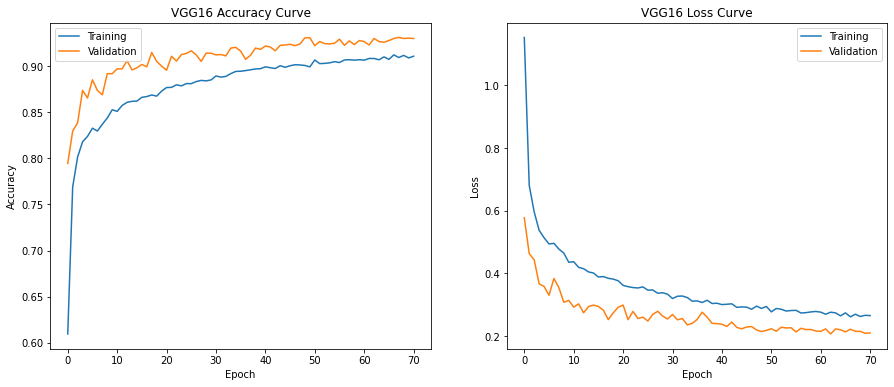

In [28]:
metrics_func = pd.DataFrame(history_func.history)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(metrics_func.accuracy, label='Training')
plt.plot(metrics_func.val_accuracy, label='Validation')
plt.title('VGG16 Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(metrics_func.loss, label='Training')
plt.plot(metrics_func.val_loss, label='Validation')
plt.title('VGG16 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

>  The loss and accuracy is not so smooth, but the score is the best compared to my baseline and my improved model

> VGG16 is the best model so far because it is resulting in 0.2 loss (remember my baseline and improved model only able to reach 1.) As well as the accuracy hits until 0.9. Note that my previous model are worse and this one is better. It's better in distinguish 10 labels since there's no Exploding/Vanishing gradient.

> This score is happening because I've set several parameters : 
> - The activation to **tanh** rather than **relu**.
> Previously when i use `relu` as activation in hidden layer, this model doesn't perform this well. I choose to change it to tanh (random) and it results better. This means tanh activation is more sensitive with my model. Why? Because tanh have the *negative value*, I assume in classifiying land use from satelite image, we need every feature like even the negative value. THat's why the tanh model perform better. But note to mention that tanh **might not always good for satelite image** because we will never know the quality of our images, right? there are lots of bad quality of iamges (too dark, too light, etc).

> - Setting learning schedule is also impacting that much to the score. By setting the initial learnign rate to 0.001, it keeps decaying for the better result(the learning rate getting smaller).  

> - from_logits = True claimed t o normalized the probability because I'm not using activation softmax as output. This claimed to have more stabilized numerical.

> Since this is the best model, I wonder how the model actually works and behaving for my datasets. I'll plot it below 


> Further, I'll save this model for predict the new coming data

Text(0.5, 1.0, 'Fig 4')

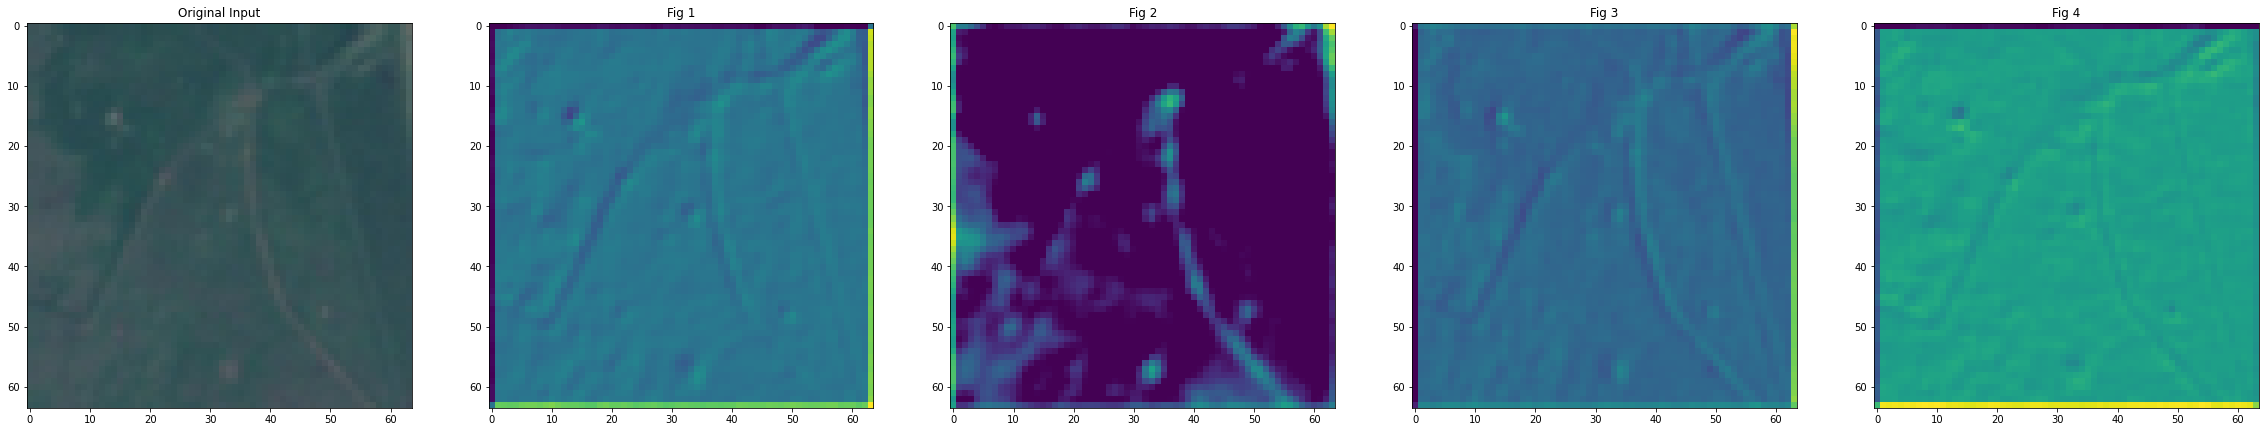

In [29]:
def cut_model(model, layer_name):
  model = tf.keras.models.Model(model.input, model.get_layer(layer_name).output)
  _sample = np.asarray(Image.open(sample))[None, : , : , :]/255.
  return model


_sample = np.asarray(Image.open(sample))[None, : , : , :]/255.
_model = cut_model(pretrained_model, 'block1_conv1')
_latent = _model(_sample)

fig, ax = plt.subplots(1, 5, figsize=(8*5, 8))
ax[0].imshow(_sample[0])
ax[0].set_title('Original Input')
ax[1].imshow(_latent[0, :,:, 0])
ax[1].set_title('Fig 1')
ax[2].imshow(_latent[0, :,:, 1])
ax[2].set_title('Fig 2')
ax[3].imshow(_latent[0, :,:, 2])
ax[3].set_title('Fig 3')
ax[4].imshow(_latent[0, :,:, 3])
ax[4].set_title('Fig 4')

The behaviour of VGG block1_conv1 is more less like this :
> 1. In Fig 1, it is sensitive with a line (not shape, but line) and it's detecting the roads
> 2. In Fig 2, it is sensitive with colour. Bright and Dark is obvious here
> 3. In Fig 3, I think it is sensitive with horizontal line even tho it'ns not much different with Fig 1
> 4. In Fig 4, the brighter the color, the shape is deeper. Compared to dark color, the shape is like *pop up* to our screen 

Actually each layer can be analyzed further, but my dataset is small so I prefer to give you a slight visualization about the VGG

We can try every layer in VGG model, but in this layer I can assume that VGG is very sensitive with colour and shape.

In [30]:
y_pred_vgg = model_func.predict(test_generator)
y_pred_vgg = np.argmax(y_pred_vgg, axis = 1)

report3 = classification_report(y_,
                               y_pred_vgg,
                               labels = np.arange(10),
                               target_names = LABELZ)
print(report3)

                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.91      0.93       300
              Forest       0.92      0.93      0.93       300
HerbaceousVegetation       0.90      0.90      0.90       300
             Highway       0.90      0.88      0.89       250
          Industrial       0.96      0.94      0.95       250
             Pasture       0.90      0.89      0.90       200
       PermanentCrop       0.95      0.86      0.90       250
         Residential       0.91      0.99      0.95       300
               River       0.92      0.92      0.92       250
             SeaLake       0.93      0.98      0.96       300

            accuracy                           0.92      2700
           macro avg       0.92      0.92      0.92      2700
        weighted avg       0.92      0.92      0.92      2700



> I need to say that this VGG model is not lack at all because it resulting in almost 90 score. THe only lack here is in Highway. Why So? Because that SeaLake is dark, unvariative color, and have no shape (tends to curving). This models weak in this features

> This means the VGG model is `Overkill` the dataset, but still weak in dark colour without shape. 

> Overall, it's increase :)

# SAVE MODEL

In [31]:
# model_func.save('model_vgg.h5') #save model so we don't have to re run the training model

In [32]:
# constructed_model = keras.models.load_model("/content/model_vgg.h5") #test for loading data

# Model Inference

## Use Random Data
If you want to use this, I'd like to suggest you to take a small size picture from [Google Earth](https://earth.google.com/web/@-6.41679567,106.55828569,97.64851015a,2264.76518943d,35y,0h,0t,0r). Or you may download the picture I've provided

In [ ]:
from google.colab import files
def predict_image() : 
  uploaded = files.upload()

  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(64,64))
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = constructed_model.predict(images)
    classes = np.argmax(classes, axis = 1)
    labels = list(train_generator.class_indices.keys())
    print(f'This is a {labels[classes.item()]} Image')
  

In [ ]:
predict_image()

> I was uploading a Forest Image from Google Colab, why it's predicted as Residential ?

In [ ]:
predict_image()

> Correct prediction

In [ ]:
predict_image()

> Correct prediction

In [ ]:
predict_image()

> Correct prediction

In [ ]:
predict_image()

> Correct prediction

In [ ]:
predict_image()

> Correct prediction

In [ ]:
predict_image()

> Correct prediction

Something went wrong here. I was uploading Forest Images from Google Earth but the model predict it's a Residential(Wrong Prediction). Next try when I upload a Permanent Crop (rice fields) it predict PermanentCrop (right). As well as the rest of inference datasets. How can 90% accuracy predicted wrong image?

The problem is in the **TRAINED DATASETS** VS **Satelite Imagery**

The Logic went here :
1. Satelite Imagery is a complex images. It captured through lots of angle, lots of sunshine (or less), most of them have textures, various colour, etc. Take a tour in Google Earth, we can see there are some area that bright, some are dark. Some are cloudy, some are not. Some has obivous texture, some not. This is why Satelite Imagery is **COMPLEX**

2. Thinking so, the dataset I used here is too **SIMPLE**. The datasets here only 1 angle capture, specific sunshine direction, specific brightness, and specific color combination.  Worst case scenario is, this dataset is lacking of Forest Image with combination of texture.

3. Those two things above is somehow contradicting, therefore this model works perfect only for **the similar images like what I've trained**. This dataset is not variative enough to be trained and this caused why it's hard to classify inference data but perfect for Test Data, because Test Data have the same *standard* like the trained data.

Looking at my Forest Image (First Image), my model never trained with that type of image. My inference Forest image has hard texture, yet my trained Forest image has smooth texture. Now my model is confuse. Take a tour in datasets, the hard texture exist in Residential Classes in Trained Set. This is why my model predict the ifnerence Forest to Residential. 

It's different with the other's inference data, my model has trained that image before with the same shape (rectangular/square), similar color, same texture, and luckily have the same brightness. This is why my model can predict the permanent crop

# Conclusions

## Data Analysis
1. There are 10 Land Classifications here : PermanentCrop, Residential, Pasture, SeaLake, AnnualCrop, Forest, River, Highway, HerbaceousVegetation, Industrial
2. The size of image is 64 ^ 64 with total 21.600 images for train
3. The image contain lots of color, there is no majority color here
4. The brightness of the dataset is not variative, it tends to have gloomy brghtness

## Model Analysis
1. Baseline model without deeper layer and neuron have bad result.
2. Improved model with adding 1 layer in each convolutional layer result in better score, improved model is sensitive with color and rectangular/square shape in image, but weak with dark color/ dark brightness and elips/circle shape.
3. With the use of VGG16 the model is improved better. Somehow it still lacking in classifying image with dark colour, less brightness, and no shape.

## Slight Insight

1. This model, architectures, and explanation is good for educational purposes.
2. Due to Satelite Imagery Complexity, please use a Good Datasets for Satelite Imagery. What's `good`? Good means it captured from lots of angle, variative sun direction, variative color, and variative texture. You really need to train **variative data** of satelite imagery.
